<a href="https://colab.research.google.com/github/jefflijun/Corona_virus/blob/master/Canada_Daily.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from datetime import date, datetime, timedelta
import seaborn as sns

from sklearn import linear_model

url_data = 'https://health-infobase.canada.ca/src/data/covidLive/covid19.csv'

df_all = pd.read_csv(url_data, error_bad_lines=False)
df_all = df_all.replace(np.nan, '', regex=True)

df_all['date'] = pd.to_datetime(df_all['date'], format='%d-%m-%Y', errors='coerce') # Change date to time format

# Replace ''in 'numdeaths' & 'numtested' to 0
df_all.loc[df_all['numdeaths'] == '',['numdeaths']] = 0
df_all.loc[df_all['numtested'] == '',['numtested']] = 0

# Change 'numdeaths' & 'numtested' type to int
df_all['numdeaths'] = df_all['numdeaths'].astype(int)
df_all['numtested'] = df_all['numtested'].astype(int)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# Generate province dataframe
start_date = '2020-03-10'
df_all = df_all[df_all['date'] > start_date]

df_Ontario = df_all[df_all['prname']=='Ontario'].sort_values(by=['date'])
df_BC = df_all[df_all['prname']=='British Columbia'].sort_values(by=['date'])
df_Alberta = df_all[df_all['prname']=='Alberta'].sort_values(by=['date'])
df_Quebec = df_all[df_all['prname']=='Quebec'].sort_values(by=['date'])
df_Canada = df_all[df_all['prname']=='Canada'].sort_values(by=['date'])

df_Canada = df_Canada.rename(columns={'numconf':'CAN_C', 'numdeaths':'CAN_D', 'numtested':'CAN_T'})
df_Canada = df_Canada[['date', 'CAN_C', 'CAN_D', 'CAN_T' ]]
#df_Canada = df_Canada[df_Canada['date'] > start_date]

df_Ontario = df_Ontario.rename(columns={'numconf':'ON_C', 'numdeaths':'ON_D', 'numtested':'ON_T'})
df_Ontario = df_Ontario[['date', 'ON_C', 'ON_D', 'ON_T' ]]
#df_Ontario = df_Ontario[df_Ontario['date'] > start_date]

df_BC = df_BC.rename(columns={'numconf':'BC_C', 'numdeaths':'BC_D', 'numtested':'BC_T'})
df_BC = df_BC[['date', 'BC_C', 'BC_D', 'BC_T' ]]
#df_BC = df_BC[df_BC['date']> start_date]

df_Alberta = df_Alberta.rename(columns={'numconf':'AB_C', 'numdeaths':'AB_D', 'numtested':'AB_T'})
df_Alberta = df_Alberta[['date', 'AB_C', 'AB_D', 'AB_T' ]]
#df_Alberta = df_Alberta[df_Alberta['date'] > start_date]

df_Quebec = df_Quebec.rename(columns={'numconf':'QC_C', 'numdeaths':'QC_D', 'numtested':'QC_T'})
df_Quebec = df_Quebec[['date', 'QC_C', 'QC_D', 'QC_T' ]]
#df_Quebec = df_Quebec[df_Quebec['date'] > start_date]

#df_Ontario.dtypes

In [0]:
# Join all provinces' dataframe
df_Canada_all = pd.merge(df_Canada, df_Ontario, on='date', how='left')
df_Canada_all = pd.merge(df_Canada_all, df_BC, on='date', how='left')
df_Canada_all = pd.merge(df_Canada_all, df_Alberta, on='date', how='left')
df_Canada_all = pd.merge(df_Canada_all, df_Quebec, on='date', how='left')

# Generate confirmed, death & tested for 'Others'
df_Canada_all['O_C'] = df_Canada_all['CAN_C'] - df_Canada_all['ON_C'] - df_Canada_all['BC_C'] - df_Canada_all['AB_C'] - df_Canada_all['QC_C']
df_Canada_all['O_D'] = df_Canada_all['CAN_D'] - df_Canada_all['ON_D'] - df_Canada_all['BC_D'] - df_Canada_all['AB_D'] - df_Canada_all['QC_D']
df_Canada_all['O_T'] = df_Canada_all['CAN_T'] - df_Canada_all['ON_T'] - df_Canada_all['BC_T'] - df_Canada_all['AB_T'] - df_Canada_all['QC_T']

In [0]:
# Calculate day gap between starting date to today
total_date = ((date.today() - datetime.strptime('03/11/2020', '%m/%d/%Y').date())).days - 2

Daily_province = ['CAN_C_D', 'CAN_D_D', 'CAN_T_D', 'ON_C_D', 'ON_D_D', 'ON_T_D', 'BC_C_D', 'BC_D_D', 'BC_T_D', 'AB_C_D',\
                  'AB_D_D', 'AB_T_D', 'QC_C_D', 'QC_D_D', 'QC_T_D', 'O_C_D', 'O_D_D', 'O_T_D']

for i in range(18):
    df_Canada_all[Daily_province[i]] = 0
    for j in range(total_date+1):
        df_Canada_all.iloc[j+1,i+18] =  df_Canada_all.iloc[j+1,i] - df_Canada_all.iloc[j,i]

# Set beging date
begin_date = '2020-03-21'
df_Canada_all = df_Canada_all[df_Canada_all['date'] > begin_date]

In [0]:
# Calculate moving avergae
pd.options.mode.chained_assignment = None #Close the warning

Moving_average_period = 10
df_Canada_all['CAN_C_MV'] = df_Canada_all.iloc[:,19].rolling(window=Moving_average_period).mean()
df_Canada_all['CAN_D_MV'] = df_Canada_all.iloc[:,20].rolling(window=Moving_average_period).mean()

#df_Canada_all.columns

In [0]:
x_place = df_Canada_all['CAN_C_D'].max()*0.99

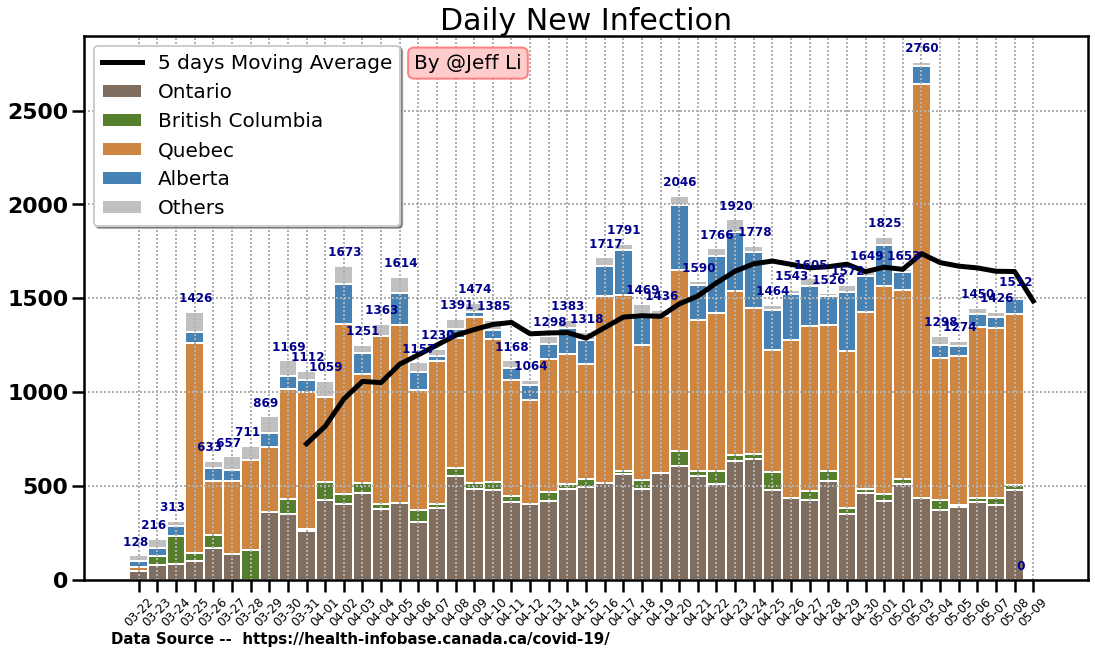

In [44]:
# Set Graph format
sns.set_context("poster")
plt.figure(figsize=(18,10))
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.linestyle"] = (1,1)

# Heights of bars1 + bars2 + bars3
ON_daily = np.array(df_Canada_all['ON_C_D'])
BC_daily = np.array(df_Canada_all['BC_C_D'])
AB_daily = np.array(df_Canada_all['AB_C_D'])
QC_daily = np.array(df_Canada_all['QC_C_D'])
Others_daily = np.array(df_Canada_all['O_C_D'])
CAN_daily = np.array(df_Canada_all['CAN_C_D'])
MV_daily = np.array(df_Canada_all['CAN_C_MV'])

bar1 = np.add(ON_daily, BC_daily).tolist()
bar2 = np.add(bar1, QC_daily).tolist()
bar3 = np.add(bar2, AB_daily).tolist()

# Names of group and bar width
names = np.array(df_Canada_all['date'].apply(lambda x: x.strftime('%m-%d')))
barWidth = 1

# The position of the bars on the x-axis
r = range(len(names))

# Create ON bars
ax = plt.bar(r, ON_daily, color='#7f6d5f', edgecolor='white', width=barWidth)
# Create BC bars (middle), on top of the firs ones
plt.bar(r, BC_daily, bottom=ON_daily, color='#557f2d', edgecolor='white', width=barWidth)
# Create QC bars (middle), on top of the second ones
plt.bar(r, QC_daily, bottom=bar1, color='#CD853F', edgecolor='white', width=barWidth)
# Create AB bars (middle), on top of the third ones
plt.bar(r, AB_daily, bottom=bar2, color='#4682B4', edgecolor='white', width=barWidth)
# Create Others bars (top)
plt.bar(r, Others_daily, bottom=bar3, color='#C0C0C0', edgecolor='white', width=barWidth)
plt.plot(r, MV_daily, color='Black',  linewidth=5)

# Add number labels
for a,b in zip(r,CAN_daily):
    plt.annotate(' %s'%(b),xy=(a, b),xytext=(-20,10), textcoords='offset points',\
                 fontsize=12, color='#00008B', fontweight='bold')

# Custom X axis, Y axis, title
plt.xticks(r, names, fontsize=12, rotation=45)

plt.yticks(fontweight='bold')
plt.title('Daily New Infection', fontsize=30, loc='center', pad=None)

# Custom legend
legend = plt.legend(['5 days Moving Average','Ontario', 'British Columbia',  'Quebec', 'Alberta', 'Others'],\
           loc='upper left', prop = {'size':20}, shadow=True)
frame = legend.get_frame()
frame.set_facecolor('1')

xmin, xmax = plt.xlim()   # return the current xlim
ymin, ymax = plt.ylim()   # return the current ylim
x1_place = xmax*0.29
y1_place = ymax*0.95
plt.text(x1_place, y1_place, "By @Jeff Li", size=20, ha="left", va="center",\
         bbox=dict(boxstyle="round",ec=(1., 0.5, 0.5),fc=(1., 0.8, 0.8),))
x2_place = -1.5
y2_place = ymax*(-0.11)
plt.text(x2_place, y2_place, "Data Source --  https://health-infobase.canada.ca/covid-19/", size=15,\
         ha="left", va="center", fontweight='bold')

plt.savefig('Canada_infection.jpg', dpi=300, transparent=False, bbox_inches='tight')
 
# Show graphic
plt.show()

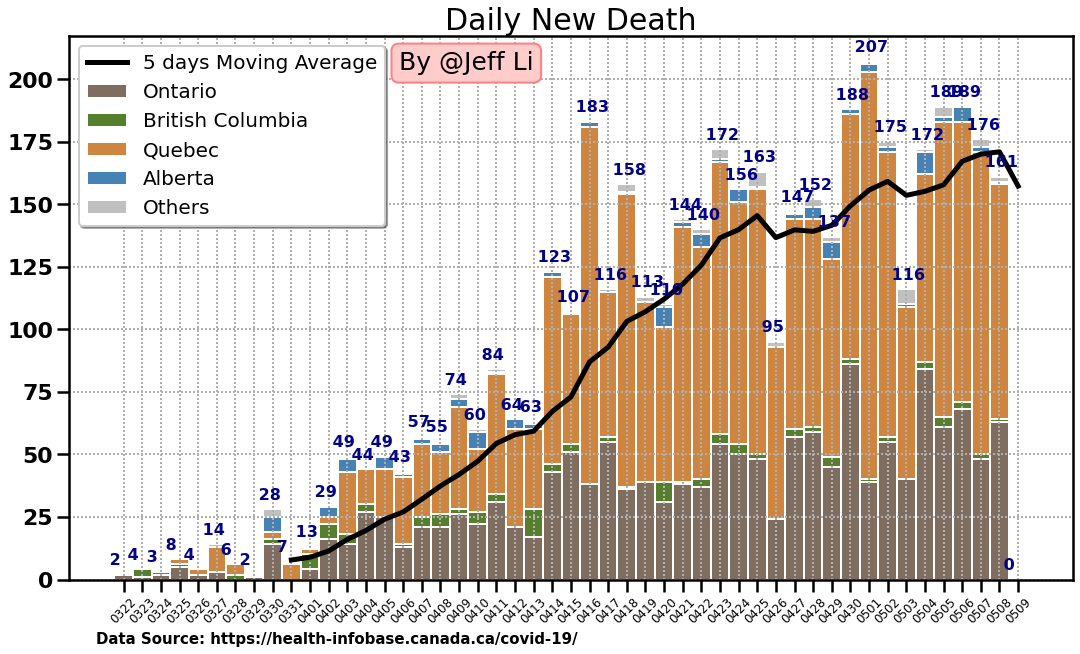

In [45]:
# Set Graph format
sns.set_context("poster")
plt.figure(figsize=(18,10))
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.linestyle"] = (1,1)

# Heights of bars1 + bars2 + bars3
ON_daily = np.array(df_Canada_all['ON_D_D'])
BC_daily = np.array(df_Canada_all['BC_D_D'])
AB_daily = np.array(df_Canada_all['AB_D_D'])
QC_daily = np.array(df_Canada_all['QC_D_D'])
Others_daily = np.array(df_Canada_all['O_D_D'])
CAN_daily = np.array(df_Canada_all['CAN_D_D'])
MV_daily = np.array(df_Canada_all['CAN_D_MV'])

bar1 = np.add(ON_daily, BC_daily).tolist()
bar2 = np.add(bar1, QC_daily).tolist()
bar3 = np.add(bar2, AB_daily).tolist()

# Names of group and bar width
names = np.array(df_Canada_all['date'].apply(lambda x: x.strftime('%m%d')))
barWidth = 1

# The position of the bars on the x-axis
r = range(len(names))

# Create ON bars
plt.bar(r, ON_daily, color='#7f6d5f', edgecolor='white', width=barWidth)
# Create BC bars (middle), on top of the firs ones
plt.bar(r, BC_daily, bottom=ON_daily, color='#557f2d', edgecolor='white', width=barWidth)
# Create QC bars (middle), on top of the second ones
plt.bar(r, QC_daily, bottom=bar1, color='#CD853F', edgecolor='white', width=barWidth)
# Create AB bars (middle), on top of the third ones
plt.bar(r, AB_daily, bottom=bar2, color='#4682B4', edgecolor='white', width=barWidth)
# Create Others bars (top)
plt.bar(r, Others_daily, bottom=bar3, color='#C0C0C0', edgecolor='white', width=barWidth)
plt.plot(r, MV_daily, color='Black',  linewidth=5)

# Add number labels
for a,b in zip(r,CAN_daily):
    plt.annotate(' %s'%(b),xy=(a, b),xytext=(-20,10), textcoords='offset points',\
                 fontsize=16, color='#00008B', fontweight='bold')

# Custom X axis, title
plt.xticks(r, names, fontsize=12, rotation=45)

plt.yticks(fontweight='bold')
plt.title('Daily New Death', fontsize=30, loc='center', pad=None)

# Custom legend
legend = plt.legend(['5 days Moving Average', 'Ontario', 'British Columbia',  'Quebec', 'Alberta', 'Others'], loc='upper left',\
                    prop = {'size':20}, shadow=True)
frame = legend.get_frame()
frame.set_facecolor('1')

xmin, xmax = plt.xlim()   # return the current xlim
ymin, ymax = plt.ylim()   # return the current ylim
x1_place = xmax*0.29
y1_place = ymax*0.95
plt.text(x_place, y_place, "By @Jeff Li", size=25, ha="left", va="center",\
         bbox=dict(boxstyle="round",ec=(1., 0.5, 0.5),fc=(1., 0.8, 0.8),))
x2_place = -1.5
y2_place = ymax*(-0.11)
plt.text(x2_place, y2_place, "Data Source: https://health-infobase.canada.ca/covid-19/", size=15,\
         ha="left", va="center", fontweight='bold')

plt.savefig('Canada_death.jpg', dpi=300, transparent=False, bbox_inches='tight')
 
# Show graphic
plt.show()

In [0]:
# Calculate date gap from Confirmed to Death
delta_d = -14 #Gap between Infection to Death

#df_Canada_f_data = df_Canada_all.set_index(pd.DatetimeIndex(df_Canada_all['date']))
date_temp = df_Canada_all[df_Canada_all['CAN_D_D']> 100]['date'].head(1) #First day daily new deaths>100 
date_temp.reset_index(drop=True,inplace=True)
date_start_D = date_temp[0] #Date format variable
date_start_C = date_start_D + timedelta(delta_d) #Mapping to infection date

df_start_C_data = df_Canada_all[df_Canada_all['date']>= date_start_C][['CAN_C_D']] #Get the data from infection starting date 
df_start_D_data = df_Canada_all[df_Canada_all['date']>= date_start_D][['CAN_D_D']] #Get the data from death starting date

df_start_C_data.reset_index(drop=True,inplace=True)
df_start_D_data.reset_index(drop=True,inplace=True)
df_start_data = df_start_C_data.join(df_start_D_data) #Combine Confirm & Death data
df_train_data = df_start_data.dropna() #Generate training data
df_test_data = df_start_data[df_start_data['CAN_D_D'].isna()]  #Generate test data

In [13]:
# Linear fit, one variables need to reshape(-1,1)
lm = linear_model.LinearRegression()
x_train = np.array(df_train_data['CAN_C_D']).reshape(-1, 1)
y_train = np.array(df_train_data['CAN_D_D'])
lm.fit(x_train, y_train)
#lm.coef_, lm.intercept_

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [0]:
# Get forecast values，fill to 'CAN_D_D_pred'
pd.options.mode.chained_assignment = None #Close the warning
x_test = np.array(df_test_data['CAN_C_D']).reshape(-1, 1)
df_test_data.loc[:,'CAN_D_D_pred'] = lm.predict(x_test) #fill forecast values in the future

df_train_data.loc[:,'CAN_D_D_pred'] = lm.predict(x_train) #fill forecast values in the past

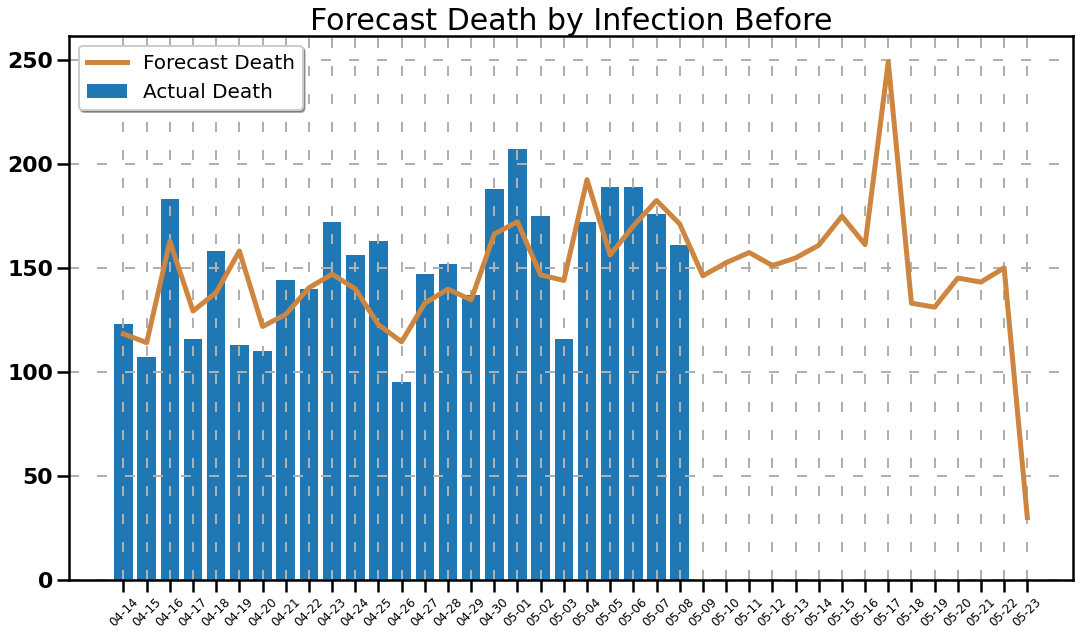

In [15]:
df_end_data = df_train_data.append(df_test_data)
sns.set_context("poster")
#sns.set()
plt.figure(figsize=(18,10))
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.linestyle"] = (1,1)

plt.yticks(fontweight='bold')
plt.title('Forecast Death by Infection Amount Before 14 Days', fontsize=30, loc='center', pad=None)

# Generate date list
r = pd.date_range(start = date_start_D, periods = len(df_end_data['CAN_D_D_pred']))
r = r.strftime('%m-%d')

plt.plot(r, 'CAN_D_D_pred', data=df_end_data, color='#CD853F',  linewidth=5)
plt.bar(r, height='CAN_D_D', data=df_end_data)
# Custom X axis, title
plt.xticks(r, r, fontsize=12, rotation=45)

plt.legend(['Forecast Death', 'Actual Death'], loc='upper left', prop = {'size':20}, shadow=True)